# Anomalies and time series decomposition

Anomalies show how much a pixel deviates from a reference condition and hence provide information whether their state is above or below expected. The reference can be a period of several years (e.g. 5-10 years depending on data availability). Anomalies can then be derived by comparing the year of interest to the reference. In addition, time series can de decomposed in several components that are associated with dynamics covering varying temporal scales, and that are associated with different processes. This allows to isolate or remove particular components for an analysis. 

In this notebook, we will illustrate several methods to calculate anomalies and decompose time series.


In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt

### **Import data**

We'll start by importing a LAI time series that was subjected to change in the year 2020. 

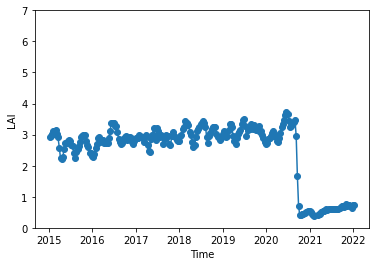

In [4]:
# Import the time series as a pandas dataframe
dat = pd.read_csv('./data/A_visualisation/area_D.csv')

dates = [pd.Timestamp(x) for x in dat['Date']]
values = np.array(dat['area_D - LAI'])

x = [datetime.strptime(x, '%d-%m-%Y') for x in dat['Date']]
y = values

plt.plot(x,y,'o-') # the 'o-' indicates that both point markers as well as lines should be plotted
plt.xlabel('Time') # this sets the x label
plt.ylabel('LAI') # this sets the y label
plt.ylim([0,7])
plt.show()

### **Anomalies**

We will first calculate anomalies of the last three years while using the four first years of the time series as a reference. Four types of anomalies will be derived:

- absolute anomalies: difference between the current vegetation index and that of the reference
- relative anomalies: ratio between the current vegetation index and the reference
- standardized anomalies: standardizes the current vegetation index using the mean and standard deviation of the reference period.
- the vegetation condition index (VCI): The VCI compares the current vegetation index to the range of values observed in the same period in previous years. It is expressed as a percentage and gives an idea where the observed value is situated between the extreme values (minimum and maximum) in the previous years.

In [5]:
import matplotlib.pyplot as plt

# statistics over the reference period (first 4 years)
y = dat['area_D - LAI']
ref = np.nanmean(np.array(y[:(36*4)]).reshape(-1,36), axis=0) # mean
std = np.nanstd(np.array(y[:(36*4)]).reshape(-1,36), axis=0) # standard deviation
mn = np.min(np.array(y[:(36*4)]).reshape(-1,36), axis=0) # minimum
mx = np.max(np.array(y[:(36*4)]).reshape(-1,36), axis=0) # maximum


# absolute anomalies
diff_y5 = y[(36*4):(36*5)] - ref
diff_y6 = y[(36*5):(36*6)] - ref
diff_y7 = y[(36*6):(36*7)] - ref

# relative anomalies
rel_y5 = 100*y[(36*4):(36*5)] / ref
rel_y6 = 100*y[(36*5):(36*6)] / ref
rel_y7 = 100*y[(36*6):(36*7)] / ref

#standardized anomalies
std_y5 = (y[(36*4):(36*5)] - ref)/std
std_y6 = (y[(36*5):(36*6)] - ref)/std
std_y7 = (y[(36*6):(36*7)] - ref)/std

# vci
vci_y5 = (y[(36*4):(36*5)]-mn)/(mx-mn)
vci_y6 = (y[(36*5):(36*6)]-mn)/(mx-mn)
vci_y7 = (y[(36*6):(36*7)]-mn)/(mx-mn)



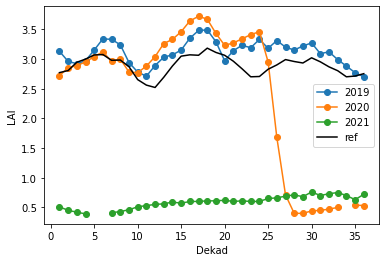

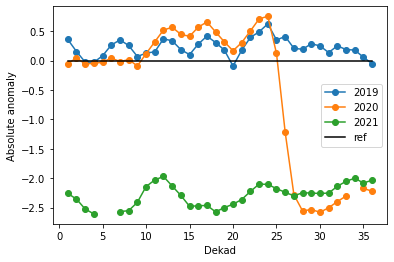

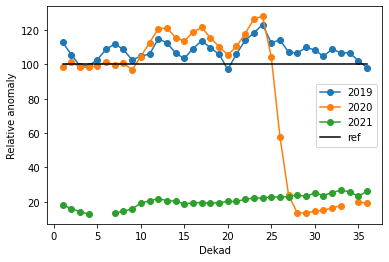

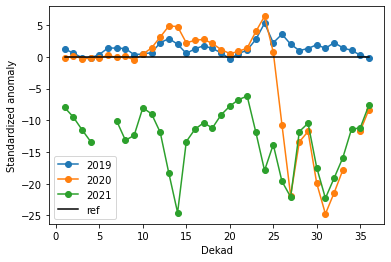

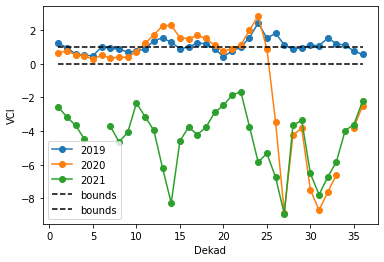

In [6]:
# Let's plot the results!

# plot the three years for which anomalies are derived together with the reference
for i in range(4,7):
    plt.plot(np.arange(1,37),y[(i*36):((i+1)*36)],'o-')
plt.plot(np.arange(1,37),ref,'-k')
plt.legend(['2019', '2020','2021','ref'])
plt.xlabel('Dekad') # this sets the x label
plt.ylabel('LAI') # this sets the y label
plt.show()

# plot the absolute anomalies
plt.plot(np.arange(1,37),diff_y5,'o-')
plt.plot(np.arange(1,37),diff_y6,'o-')
plt.plot(np.arange(1,37),diff_y7,'o-')
plt.plot(np.arange(1,37),np.zeros(36),'-k')
plt.legend(['2019', '2020','2021','ref'])
plt.xlabel('Dekad') # this sets the x label
plt.ylabel('Absolute anomaly') # this sets the y label
plt.show()

# plot the relative anomalies
plt.plot(np.arange(1,37),rel_y5,'o-')
plt.plot(np.arange(1,37),rel_y6,'o-')
plt.plot(np.arange(1,37),rel_y7,'o-')
plt.plot(np.arange(1,37),np.ones(36)*100,'-k')
plt.legend(['2019', '2020','2021','ref'])
plt.xlabel('Dekad') # this sets the x label
plt.ylabel('Relative anomaly') # this sets the y label
plt.show()

# plot the standardized anomalies
plt.plot(np.arange(1,37),std_y5,'o-')
plt.plot(np.arange(1,37),std_y6,'o-')
plt.plot(np.arange(1,37),std_y7,'o-')
plt.plot(np.arange(1,37),np.zeros(36),'-k')
plt.legend(['2019', '2020','2021','ref'])
plt.xlabel('Dekad') # this sets the x label
plt.ylabel('Standardized anomaly') # this sets the y label
plt.show()

# plot the VCI
plt.plot(np.arange(1,37),vci_y5,'o-')
plt.plot(np.arange(1,37),vci_y6,'o-')
plt.plot(np.arange(1,37),vci_y7,'o-')
plt.plot(np.arange(1,37),np.ones(36),'--k')
plt.plot(np.arange(1,37),np.zeros(36),'--k')
plt.legend(['2019', '2020','2021','bounds', 'bounds'])
plt.xlabel('Dekad') # this sets the x label
plt.ylabel('VCI') # this sets the y label
plt.show()

### **Time series decomposition: Seasonal-Trend decomposition using LOESS (STL)**

STL decomposes a time series in three components: (i) seasonality or seasonal, (ii) trend, and (iii) remainder. The seasonal component is characterized by regularly spaced and consistent peaks and thoughs that have approximately the same magnitude. The seasonal component of NDVI time series spanning multiple years is often driven by annual temperature, climate, and seasons, or growth seasons of the vegetation. The trend component represents the long term change in a time series, excluding the calender related or irregular effects. The remainder component is often associated with remaining aretefacts in the data (e.g. due to clouds) or due to irregular, short-term deviations from the expected trend and seasonal pattern (e.g. due to droughts).

More information about the STL parameters can be found in https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html.

In [8]:
# prepare data
lai = pd.Series(values, index=dates, name="LAI")
print(lai.describe())

# resample to monthly observations using mean values 
# interpolate missing values
lai_month = lai.resample("1M").mean().interpolate()
print(lai_month)

count    250.000000
mean       2.536000
std        0.947251
min        0.390000
25%        2.610000
50%        2.895000
75%        3.107500
max        3.720000
Name: LAI, dtype: float64
2015-01-31    3.0000
2015-02-28    3.0950
2015-03-31    2.7450
2015-04-30    2.2600
2015-05-31    2.7350
               ...  
2022-06-30    0.7140
2022-07-31    0.7205
2022-08-31    0.7270
2022-09-30    0.7335
2022-10-31    0.7400
Freq: M, Name: LAI, Length: 94, dtype: float64


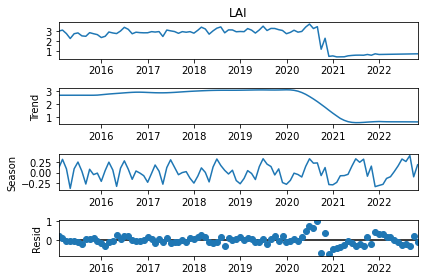

In [9]:
# STL decomposition
stl = STL(lai_month, 
          seasonal=17, 
          trend=None, 
          low_pass=None, 
          seasonal_deg=50, 
          trend_deg=0, 
          low_pass_deg=0, 
          robust=False, 
          seasonal_jump=1, 
          trend_jump=1, 
          low_pass_jump=1)

# let's plot the result
res = stl.fit()
fig = res.plot()

### **Classical additive decomposition**

In additive decomposition, the sum of all components equals the time series. In the decomposition method illustrated below, the trend component is first estimated using a moving average filter. The seasonal component is subsequently estimated as the average of the detended (time series - trend) time series per season. As such, the seasonal component is constant from year to year. Finally, the residual equals the time series after subtracting the trend and seasonal component.

[-0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.19339199 -0.27524616
 -0.17324318  0.02168836 -0.03583842 -0.17978613  0.15459194  0.3878211
  0.1869711   0.09224193 -0.0526539   0.06684535 -0.193391

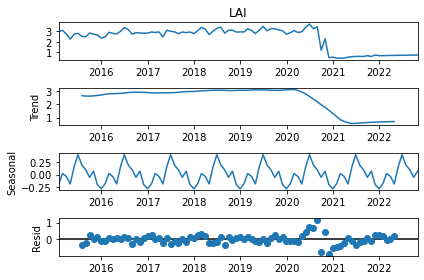

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose time series
decomp = seasonal_decompose(lai_month, model='additive')
# individual components, such as the seasonal component, can be extracted
print(decomp.seasonal.to_numpy())
#let's plot all components
seasonal_decompose(lai_month, model='additive').plot()
plt.show()

### **Classical multiplicative decomposition**

In multiplicative decomposition, the product of all components equals the original time series. The decomposition illustrated here is similar to the additive decomposition, except that subtractions are replaced by divisions.

[0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.16444173
 1.09226876 1.06546662 0.98742564 1.04683334 0.915858   0.87394384
 0.9016833  0.97292381 0.96221684 0.93980235 1.07713575 1.1644

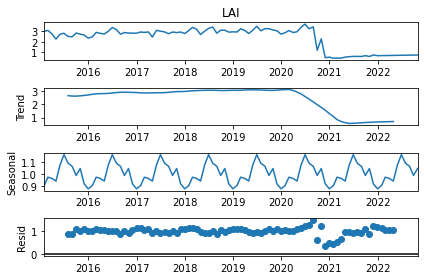

In [11]:
# let's also apply a multiplicative decomposition
decomp_mult = seasonal_decompose(lai_month, model='multiplicative')
# similarly to the additive decomposition the seasonal component can be extracted
print(decomp_mult.seasonal.to_numpy())
# let's also plot the components
decomp_mult.plot()
plt.show()

### **Now it's your turn!**

**Question**: load the time series stored in './data/A_visualisation/area_A.csv' and calculate the following:

- the relative anomlies of the last three years using a reference period of the first four years
- STL decomposition using monthly observations using (i) seasonnal = 13 and trend = 13, (ii) seasonal = 59 and trend =13, (iii) seasonal = 13 and trend = 59. Plot the resulting seasonal and trend components on top of each other. Do they differ? In what sense?